# Test results analysis for the Learn to Act phase

### Import packages and data

In [ ]:
import pickle
from google.colab import drive
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt



In [ ]:
# Mount drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
def save_data(data, filename):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)
# Function to load data from a file
def load_data(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    return data

### Compute the means of the test metris collected for the different agents and learning approaches

In [ ]:
REMOVE_OUTLIERS = False
AE_MSE = False # True only with remove_out=False

In [ ]:
if AE_MSE:
  # Define the file paths
  file_paths = ["/content/drive/MyDrive/Colab_Notebooks/test_metrics_learn_to_act/reg_sl_ae_mse.pkl", "/content/drive/MyDrive/Colab_Notebooks/test_metrics_learn_to_act/reg_ssl_ae_mse.pkl",
                "/content/drive/MyDrive/Colab_Notebooks/test_metrics_learn_to_act/cb_sl_ae_mse.pkl", "/content/drive/MyDrive/Colab_Notebooks/test_metrics_learn_to_act/cb_ssl_ae_mse.pkl",
                "/content/drive/MyDrive/Colab_Notebooks/test_metrics_learn_to_act/reg_sl_ae_mse_real.pkl", "/content/drive/MyDrive/Colab_Notebooks/test_metrics_learn_to_act/reg_ssl_ae_mse_real.pkl",
                "/content/drive/MyDrive/Colab_Notebooks/test_metrics_learn_to_act/cb_sl_ae_mse_real.pkl", "/content/drive/MyDrive/Colab_Notebooks/test_metrics_learn_to_act/cb_ssl_ae_mse_real.pkl"]
else:
  # Define the file paths
  file_paths = ["/content/drive/MyDrive/Colab_Notebooks/test_metrics_learn_to_act/reg_sl_3.pkl", "/content/drive/MyDrive/Colab_Notebooks/test_metrics_learn_to_act/reg_ssl_3.pkl",
                "/content/drive/MyDrive/Colab_Notebooks/test_metrics_learn_to_act/cb_sl_3.pkl", "/content/drive/MyDrive/Colab_Notebooks/test_metrics_learn_to_act/cb_ssl_3.pkl",
                "/content/drive/MyDrive/Colab_Notebooks/test_metrics_learn_to_act/reg_sl_3_real.pkl", "/content/drive/MyDrive/Colab_Notebooks/test_metrics_learn_to_act/reg_ssl_3_real.pkl",
                "/content/drive/MyDrive/Colab_Notebooks/test_metrics_learn_to_act/cb_sl_3_real.pkl", "/content/drive/MyDrive/Colab_Notebooks/test_metrics_learn_to_act/cb_ssl_3_real.pkl"]


In [ ]:
def add_unique_values(existing_list, values_to_add):
    for value in values_to_add:
        if value not in existing_list:
            existing_list.append(value)

def find_outliers_iqr(data):
    if any(item is None for item in data):
      outlier_indices = []
    else:
      # Calculate first and third quartiles
      q1, q3 = np.percentile(data, [25, 75])

      # Calculate interquartile range (IQR)
      iqr = q3 - q1

      # Calculate outlier thresholds
      lower_bound = q1 - (1.5 * iqr)
      upper_bound = q3 + (1.5 * iqr)

      # Find outlier indices
      outlier_indices = np.where((data < lower_bound) | (data > upper_bound))[0]

    return outlier_indices

def remove_outliers(metrics_list, metric_names):
  outlier_indices =[]
  for metric_index, metric_name in enumerate(metric_names):
    metric_values = [metrics[metric_index] for metrics in metrics_list]
    add_unique_values(outlier_indices, find_outliers_iqr(metric_values))

  # Create clean metric list with outliers removed at corresponding positions
  clean_metrics_list = []

  clean_metrics = []
  for metric_index, metric_name in enumerate(metric_names):
    clean_metric_values = []
    metric_values = [metrics[metric_index] for metrics in metrics_list]
    for j, val in enumerate(metric_values):
        if j not in outlier_indices:
          clean_metric_values.append(val)

    clean_metrics.append(clean_metric_values)

  clean_metrics_list = [[row[i] for row in clean_metrics] for i in range(len(clean_metrics[0]))]


  return clean_metrics_list



In [ ]:
def compute_means(file_paths, metric_names, remove_out = False):
    means_files = []

    # Load data from pickle files and compute means
    for file_path in file_paths:
        with open(file_path, 'rb') as file:
            metrics_list = pickle.load(file)
            if remove_out:
                # Remove outliers using the function (adjust iqr_multiplier if needed)
                metrics_list = remove_outliers(metrics_list, metric_names)
            means = []
            # Take the list of elements (each element is a list of 7 metrics)
            for metric_index, metric_name in enumerate(metric_names):
                metric_values = [metrics[metric_index] for metrics in metrics_list]
                if any(value is None for value in metric_values):
                    mean = None
                else:
                    mean = sum(metric_values) / len(metrics_list)
                means.append(mean)

            means_files.append(means)

    return means_files

def print_means(means_files, file_names, metric_names, output_file_path):
    with open(output_file_path, 'w') as output_file:
        # Print means for each file along with the corresponding mean names
        for f, file_name in enumerate(file_names):
            print('\033[1m' + f"Means for test metrics of {file_name}" + '\033[0m')
            output_file.write("Means for test metrics of " + file_name + "\n")
            for j, metric_name in enumerate(metric_names):
                print(metric_name + ":", means_files[f][j])
                output_file.write(metric_name + ": " + str(means_files[f][j]) + "\n\n")
            output_file.write("\n")
            print()

In [ ]:
# Define the names for mean elements
metric_names = [
    "mse_loss ground vs. gen.",
    "ground_vs_gen. traj_dist.",
    "ground articulated vs simplified traj_dist.",
    "ground sl_vs_ssl (simplified) traj_dist",
    "ground sl_vs_ssl gan_error",
    "ground sl_vs_ssl ae_error",
    "ground sl_vs_ssl map_error"
]

file_names = [
    "Regressor SL (Sim)",
    "Regressor SSL (Sim)",
    "CB SL (Sim)",
    "CB SSL (Sim)",
    "Regressor SL (Real)",
    "Regressor SSL (Real)",
    "CB SL (Real)",
    "CB SSL (Real)"
]

# Compute and printout the test metrics means

output_file_path = '/content/drive/MyDrive/Colab_Notebooks/test_metrics_learn_to_act/output.txt'
means_files = compute_means(file_paths, metric_names,remove_out=REMOVE_OUTLIERS)
print_means(means_files, file_names, metric_names, output_file_path)

Means for test metrics of Regressor SL (Sim)
mse_loss ground vs. gen.: 5159.647429684641
ground_vs_gen. traj_dist.: 39.013099354407615
ground articulated vs simplified traj_dist.: 3.740027996236654
ground sl_vs_ssl (simplified) traj_dist: 33.34655763819891
ground sl_vs_ssl gan_error: 12.002792285605329
ground sl_vs_ssl ae_error: 0.4610687401110031
ground sl_vs_ssl map_error: 0.9356276410634525

Means for test metrics of Regressor SSL (Sim)
mse_loss ground vs. gen.: 4689.198731919384
ground_vs_gen. traj_dist.: 37.56832547855548
ground articulated vs simplified traj_dist.: 3.7400279962473335
ground sl_vs_ssl (simplified) traj_dist: 33.34655763111133
ground sl_vs_ssl gan_error: 12.002792285605329
ground sl_vs_ssl ae_error: 0.4610687401110031
ground sl_vs_ssl map_error: 0.9356276410634525

Means for test metrics of CB SL (Sim)
mse_loss ground vs. gen.: 5108.925289583158
ground_vs_gen. traj_dist.: 39.95504553146165
ground articulated vs simplified traj_dist.: 3.740027996231729
ground sl_vs_

### Plot test metrics comparison

#### Plot of test metrics for each agent and learning approach case

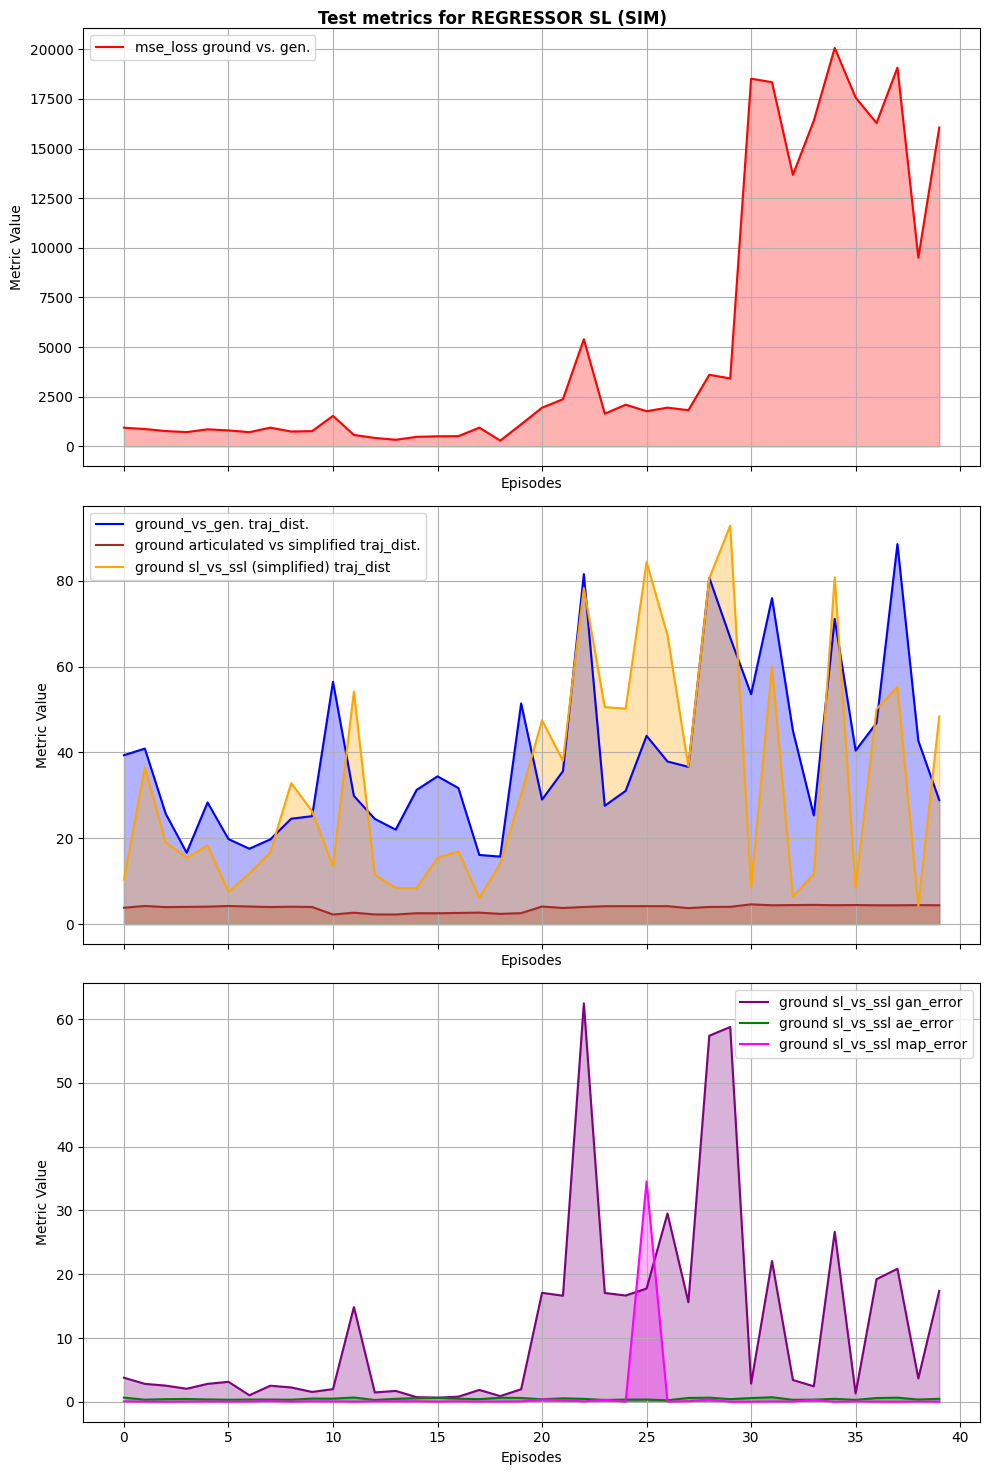

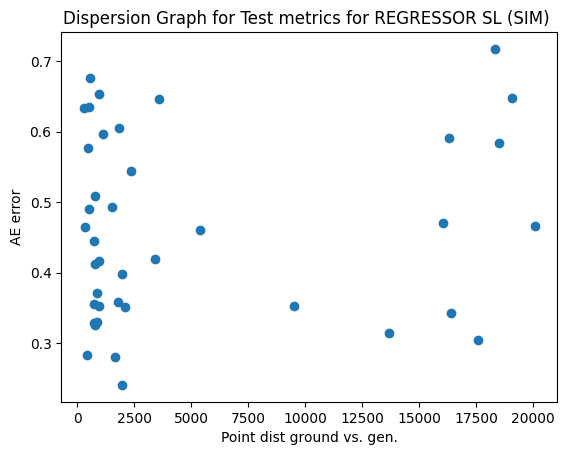

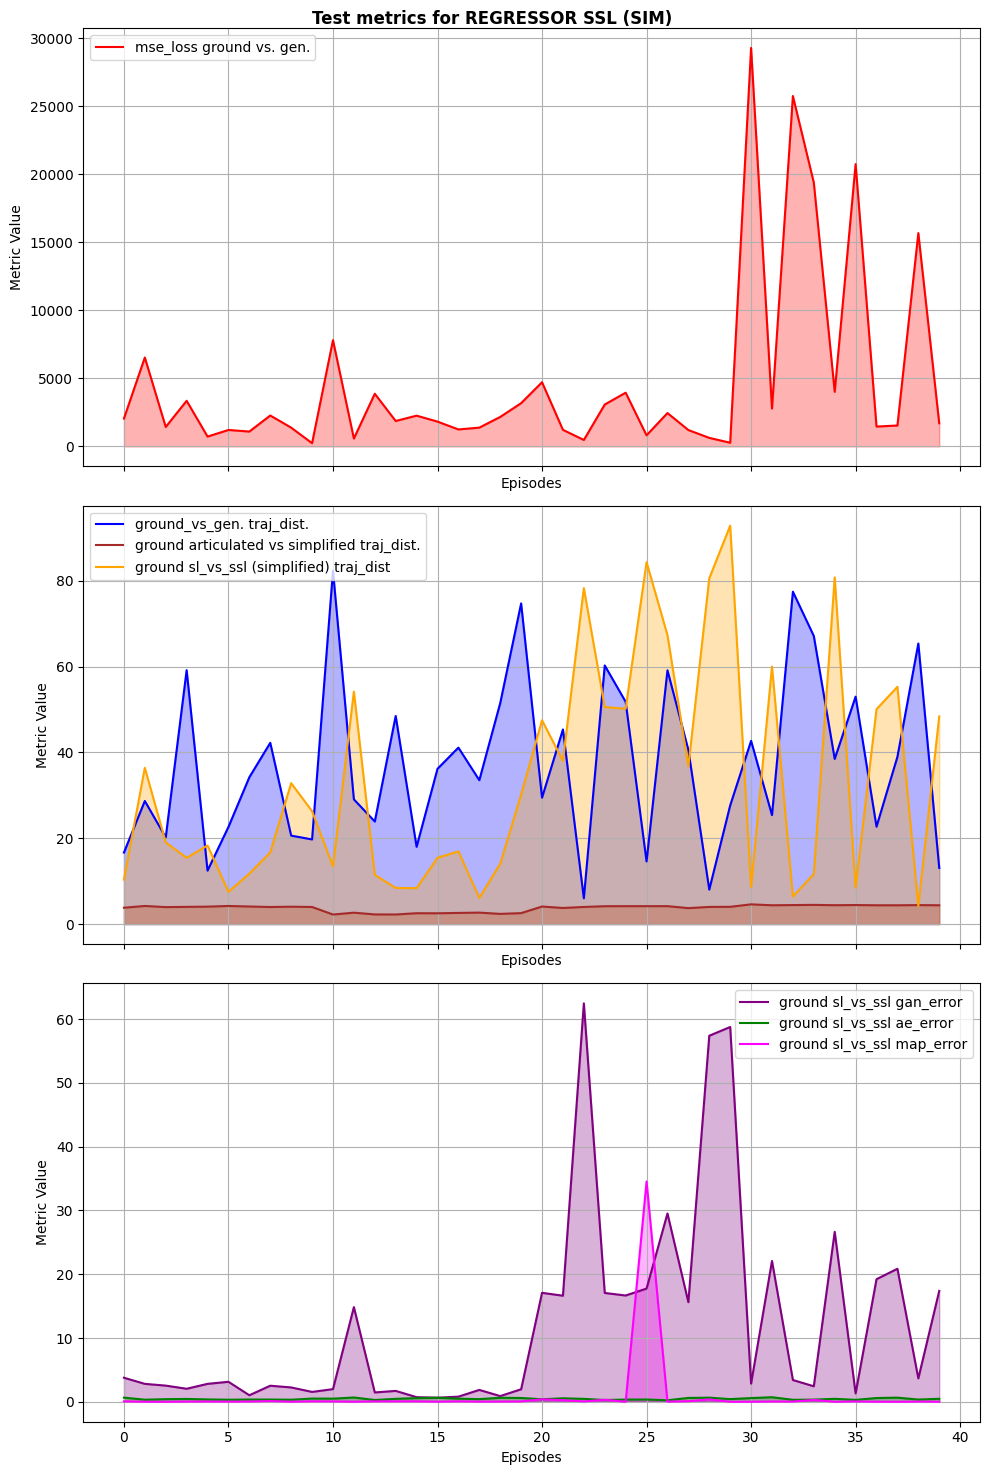

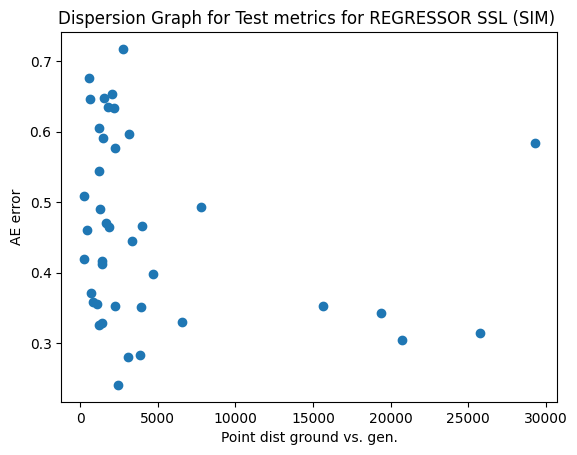

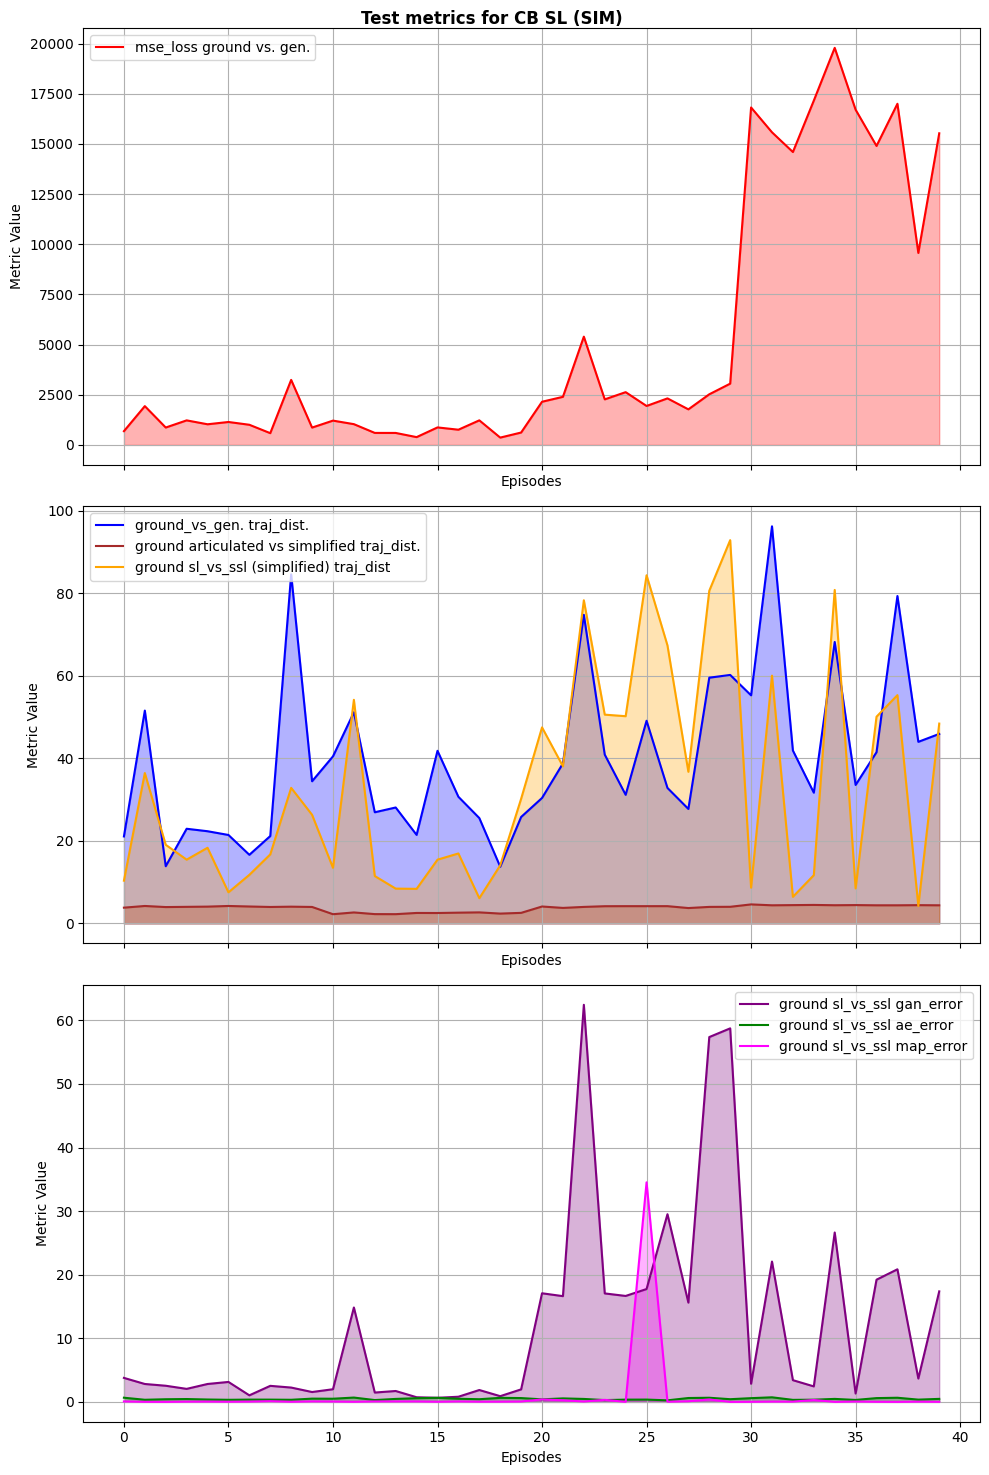

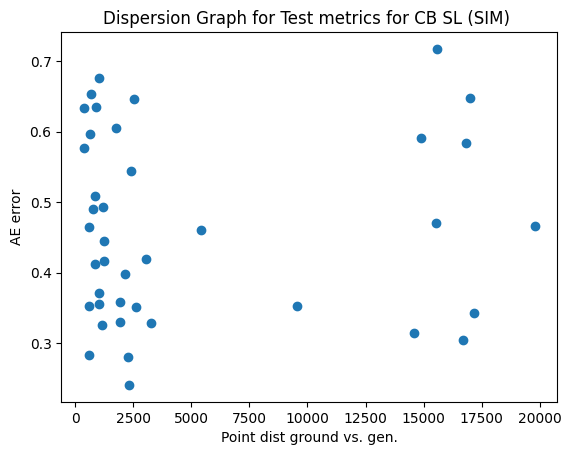

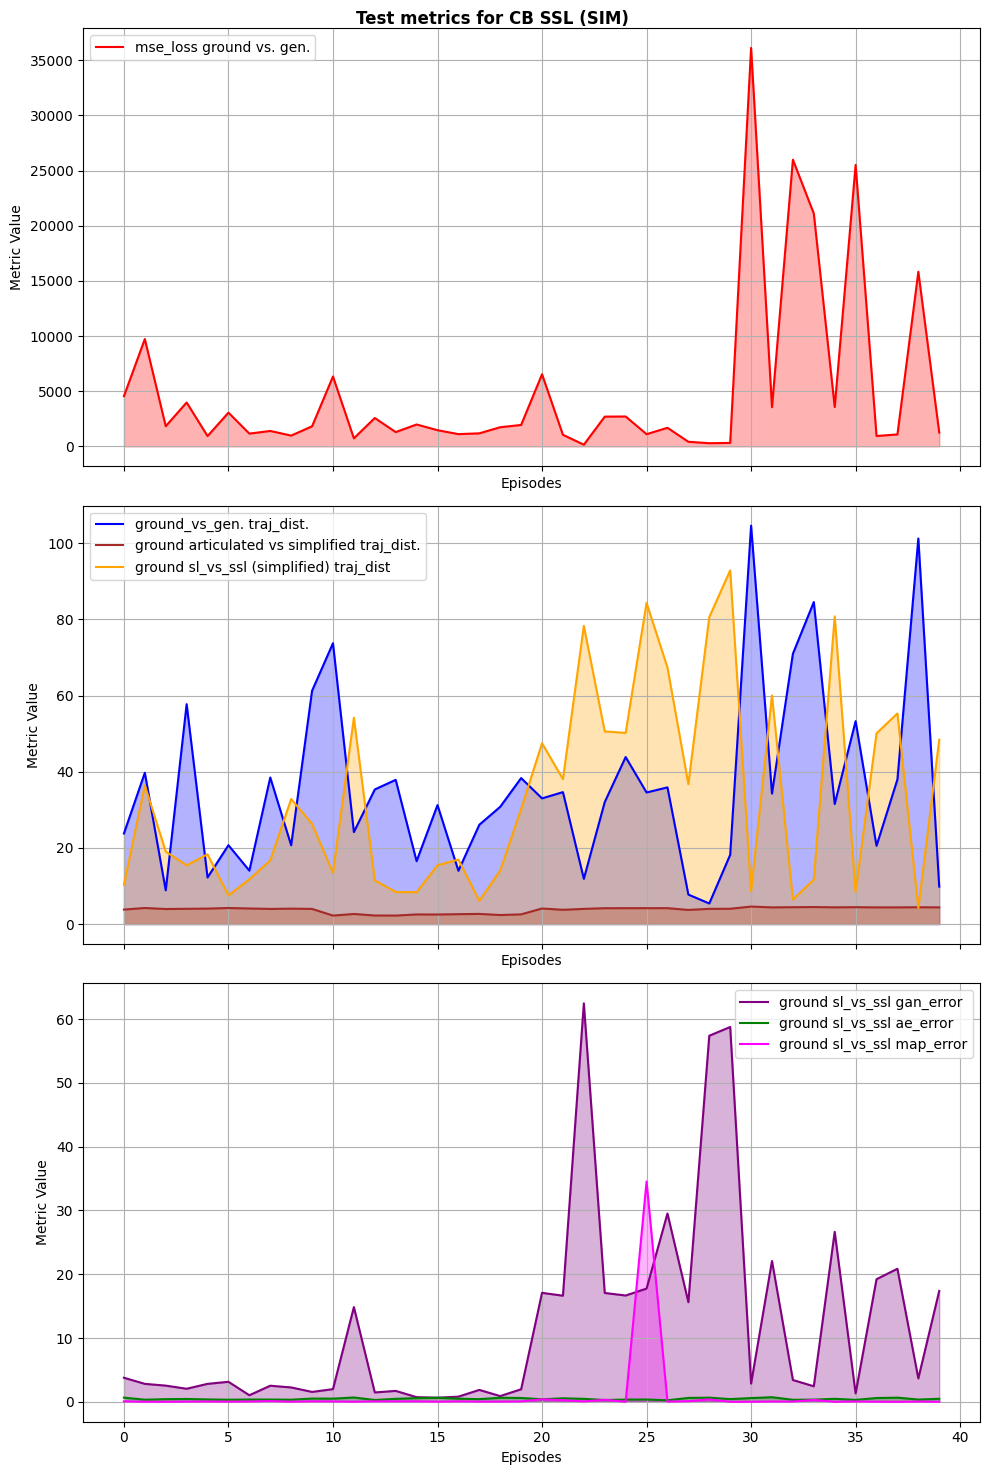

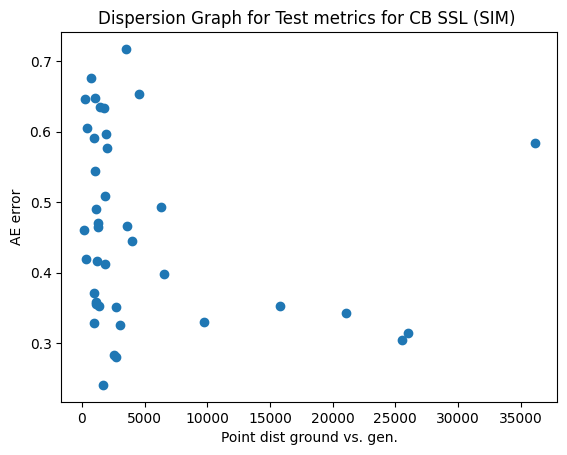

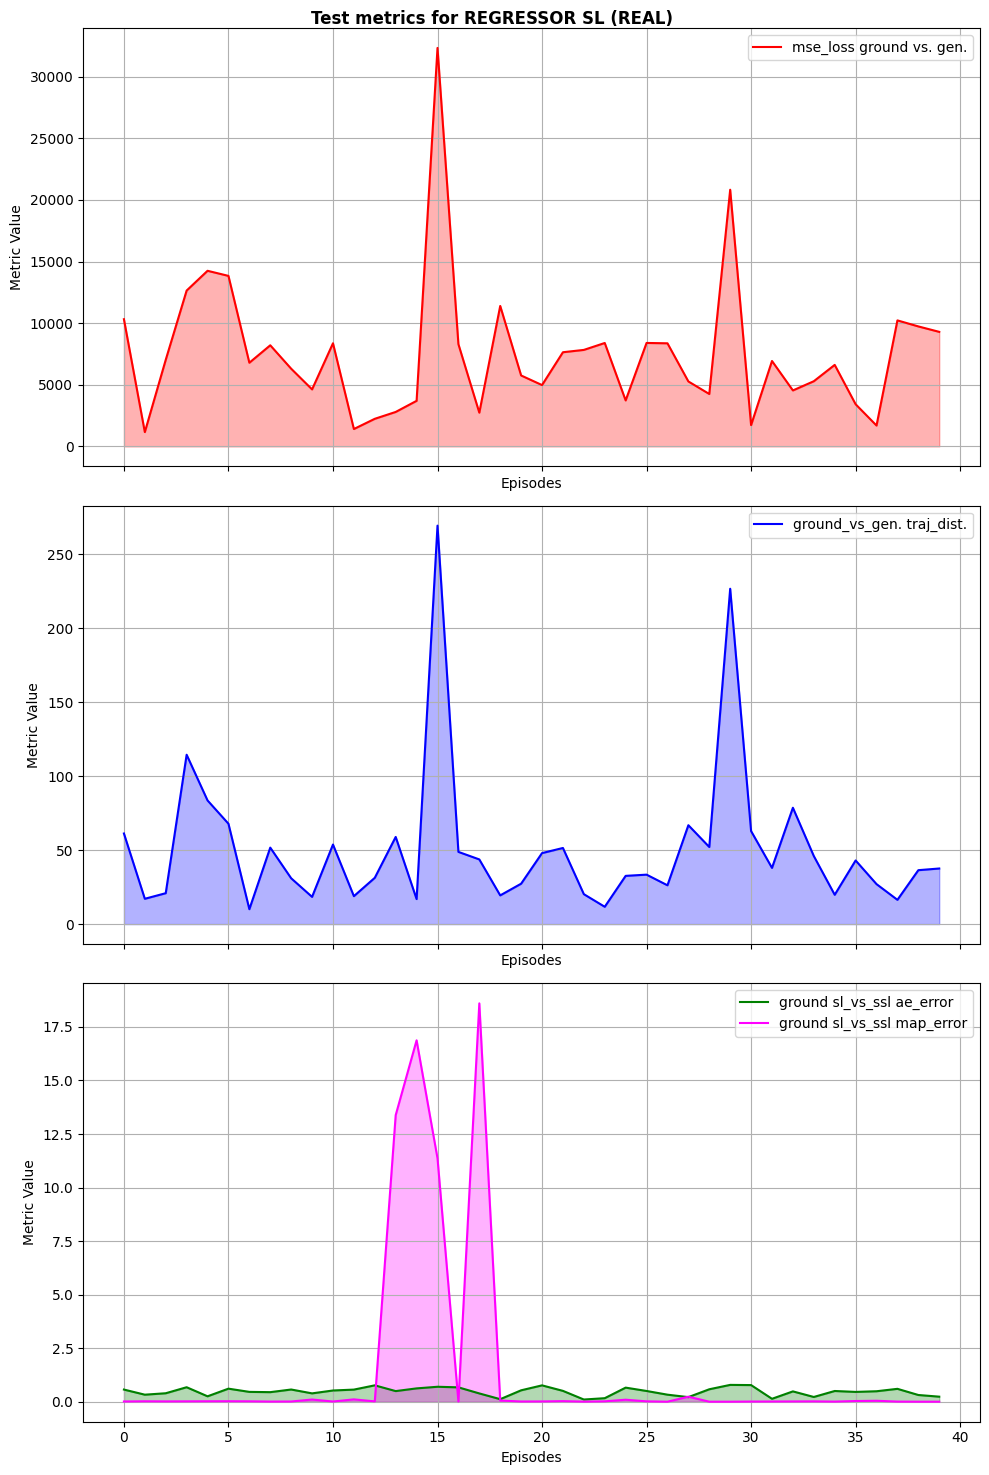

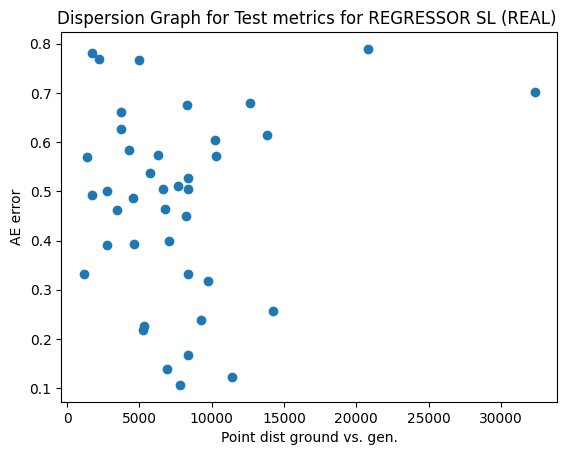

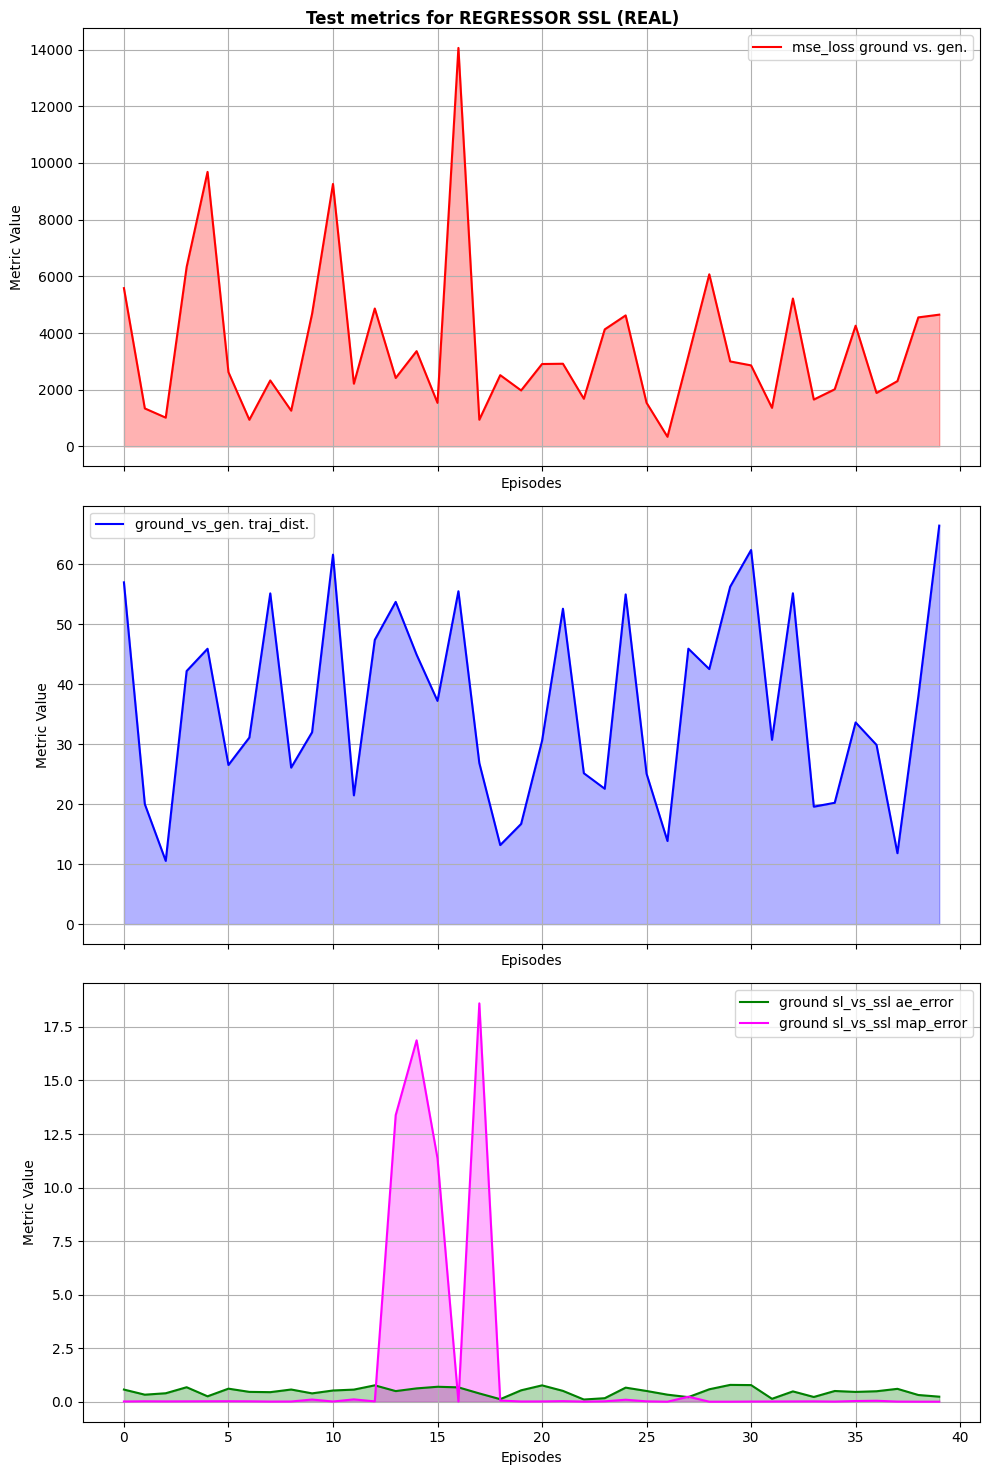

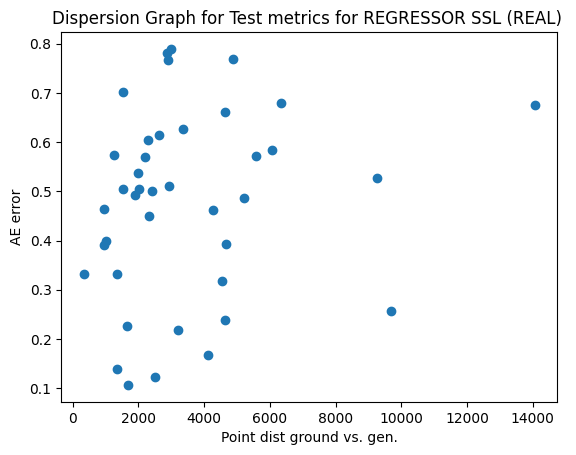

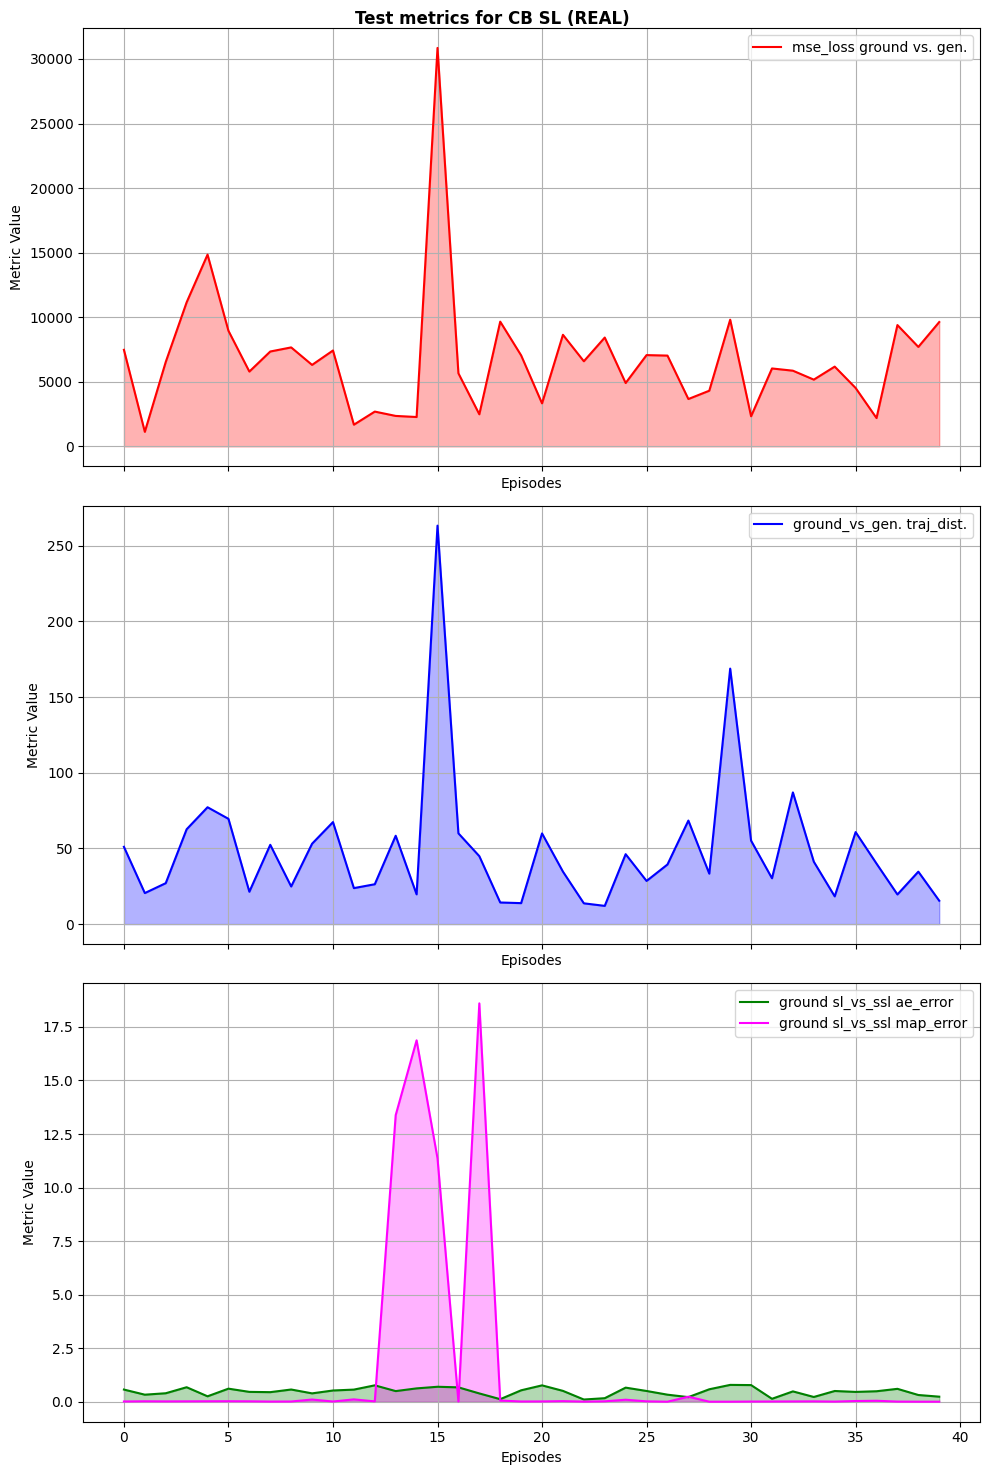

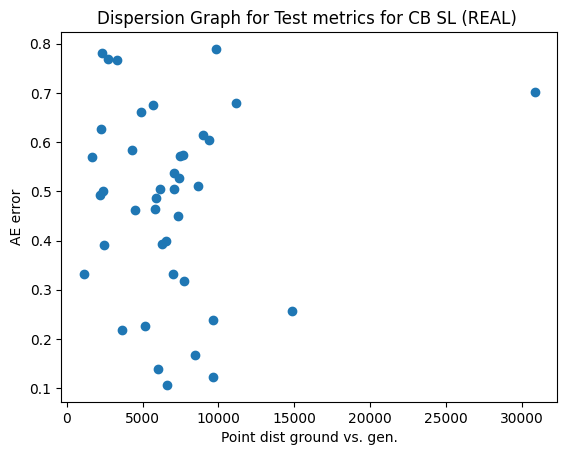

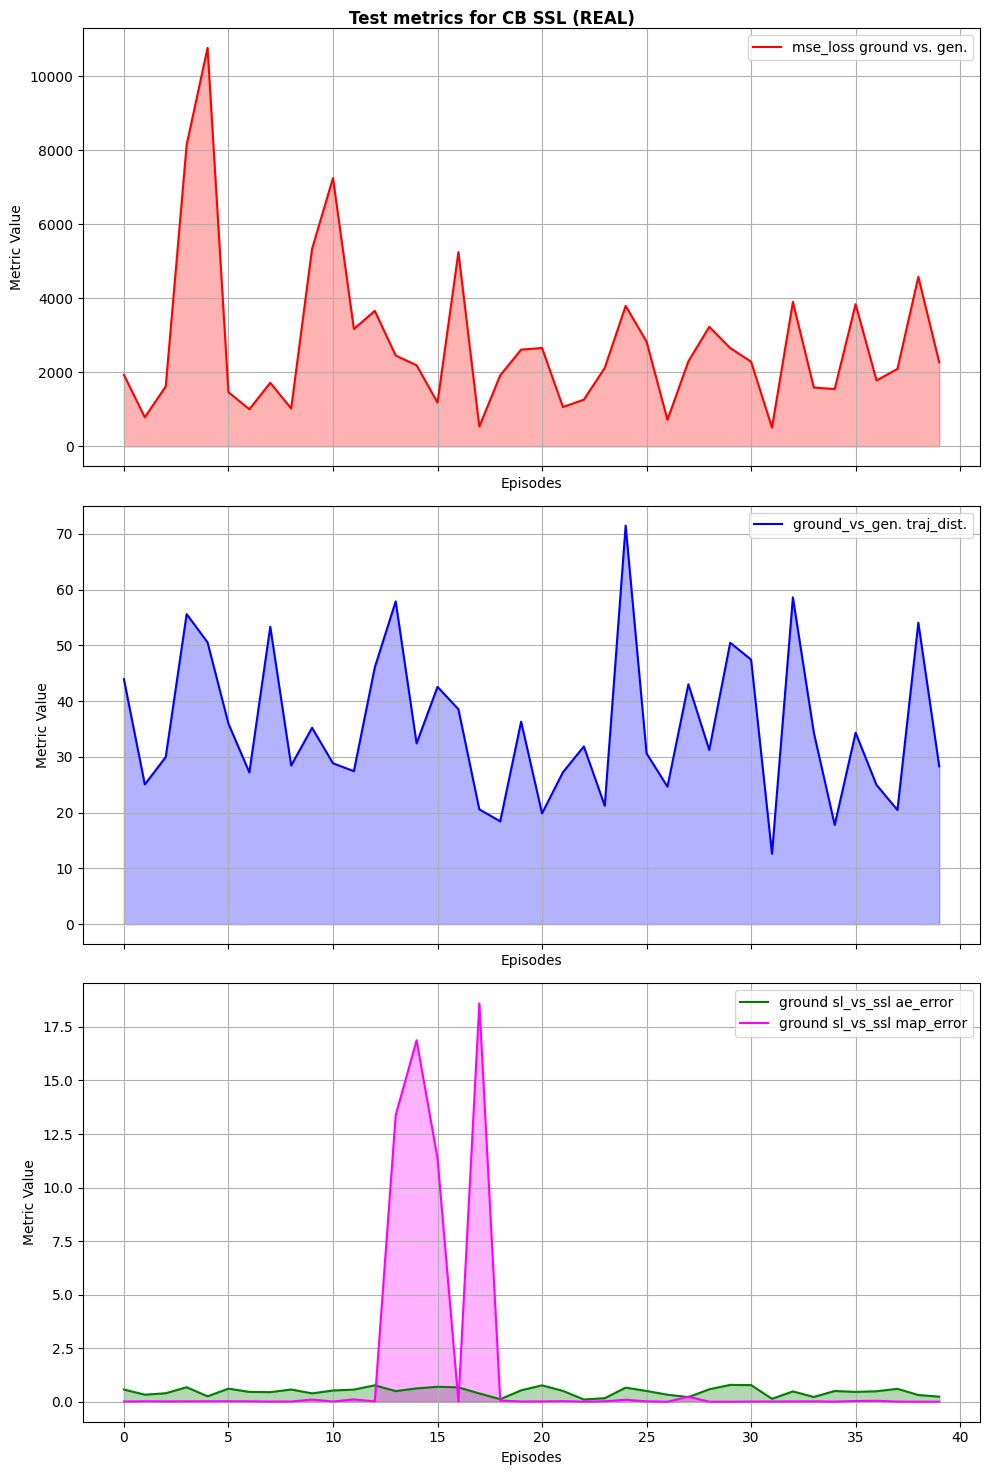

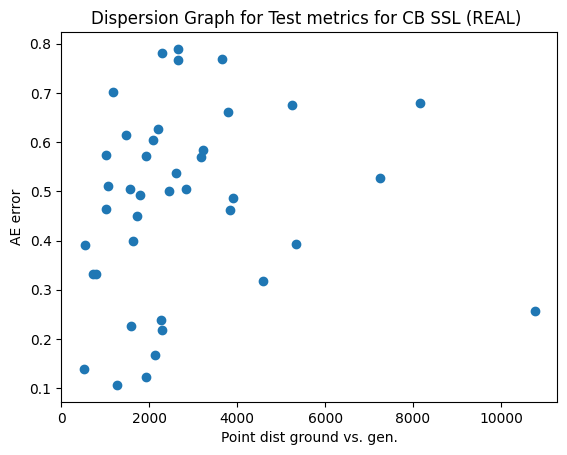

In [ ]:
def plot_metrics(save_dir, metrics_list, metric_names,  ENV_TYPE, TRAIN_MODE, title='test_metrics', remove_out=False):
    if remove_out:
        # Remove outliers using the function (adjust iqr_multiplier if needed)
        metrics_list = remove_outliers(metrics_list, metric_names)
    num_metrics = len(metrics_list[0])  # Number of metrics in each element of the list

    colors = ['red', 'blue', 'brown', 'orange', 'purple', 'green', 'magenta']  # Specify colors for the lines

    # Create a separate plot for each metric
    fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

    for metric_index, (metric_name, color) in enumerate(zip(metric_names, colors)):

        metric_values = [metrics[metric_index] for metrics in metrics_list]

        if metric_index == 0:
            axes[0].plot(np.arange(len(metrics_list)), metric_values, label=metric_name, color=color)
            axes[0].fill_between(np.arange(len(metrics_list)), metric_values, color=color, alpha=0.3)
            if metric_index == 0:
              data1 = metric_values
        elif (ENV_TYPE=="SIM" and 1 <= metric_index <= 3) or (ENV_TYPE=="REAL" and metric_index == 1):
            axes[1].plot(np.arange(len(metrics_list)), metric_values, label=metric_name, color=color)
            axes[1].fill_between(np.arange(len(metrics_list)), metric_values, color=color, alpha=0.3)

        elif (ENV_TYPE=="SIM" and 4 <= metric_index <= 6) or (ENV_TYPE=="REAL" and 5 <= metric_index <= 6):
            axes[2].plot(np.arange(len(metrics_list)), metric_values, label=metric_name, color=color)
            axes[2].fill_between(np.arange(len(metrics_list)), metric_values, color=color, alpha=0.3)
            if metric_index == 5:
              data2 = metric_values

    fig.suptitle(title + TRAIN_MODE + ' ('+ENV_TYPE+ ') ', fontweight='bold')
    for ax in axes:
        ax.set_xlabel("Episodes")
        ax.set_ylabel("Metric Value")
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    # Save the figure
    figure_file = save_dir + TRAIN_MODE + '_' + title + '_' + ENV_TYPE + '.png'
    plt.show()
    plt.close()

    # Creazione del grafico a dispersione
    plt.scatter(data1, data2)

    # Etichette degli assi e titolo del grafico
    plt.xlabel("Point dist ground vs. gen.")
    plt.ylabel("AE error")
    plt.title("Dispersion Graph for "+ title + TRAIN_MODE + ' ('+ENV_TYPE+ ') ')

    # Visualizzazione del grafico
    plt.show()


for f,file_path in enumerate(file_paths):
    with open(file_path, 'rb') as file:
        metrics_list = pickle.load(file)
        if f==0 or f==2 or f==4 or f==6:
          train_mode = "SL"
        else:
          train_mode = "SSL"
        if f<2 or 3<f<6:
          title_name = "REGRESSOR "
        else:
          title_name = "CB "
        if f<4:
          env_type = "SIM"
        else:
          env_type = "REAL"
        plot_metrics('/content/drive/MyDrive/Colab_Notebooks/test_metrics_learn_to_act/', metrics_list, metric_names, env_type, train_mode, title="Test metrics for "+title_name, remove_out=REMOVE_OUTLIERS)

#### Plot the metrics means Sim vs Real

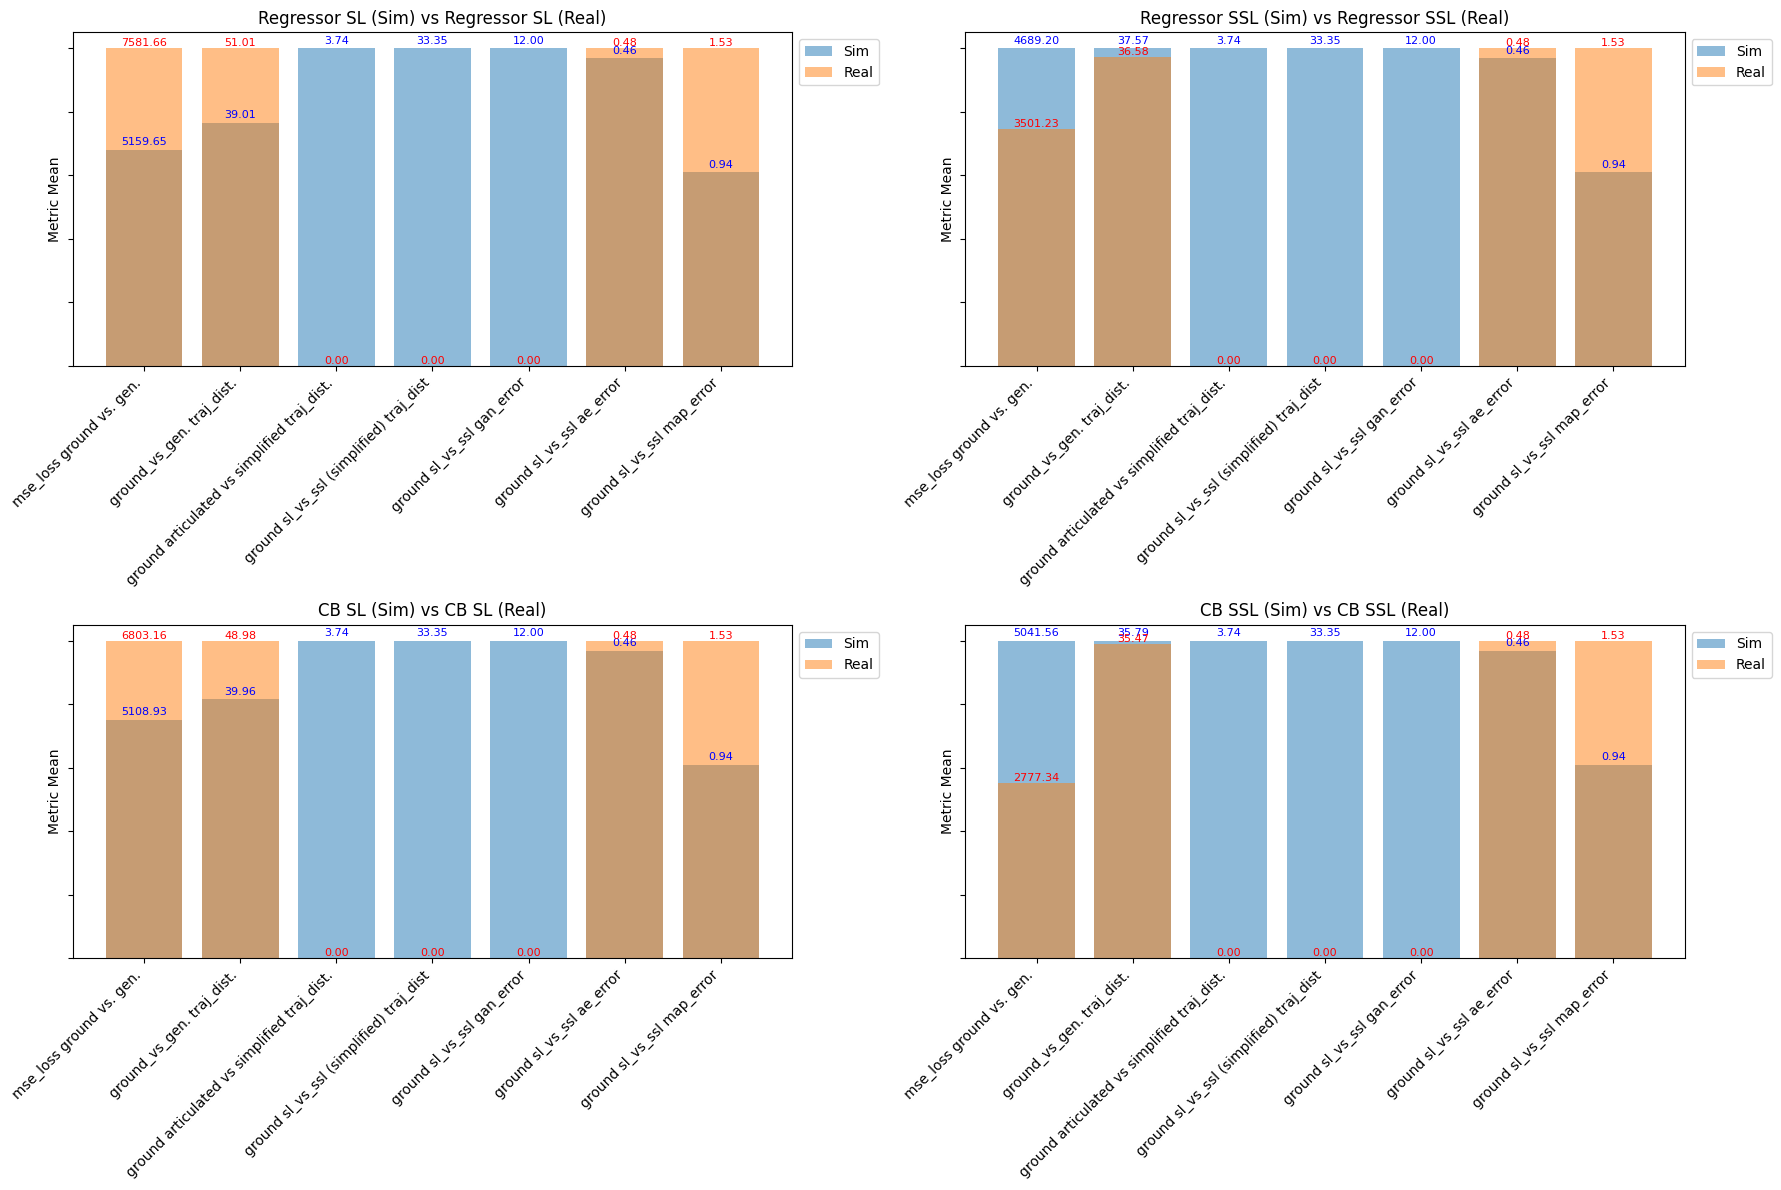

In [ ]:
def plot_comparison(means_files, file_names, metric_names):
    fig, axs = plt.subplots(2, 2, figsize=(18, 12))

    for i, ax in enumerate(axs.flat):
        x = range(len(metric_names))
        y1 = [val if val is not None else 0 for val in means_files[i]]  # First category
        y2 = [val if val is not None else 0 for val in means_files[i + 4]]  # Corresponding category from the last four
        max_values = [max(val1, val2) for (val1, val2) in zip(y1, y2)]

        # Scale values between 0 and 1
        y1_scaled = [val / max_value  for (val, max_value) in zip(y1, max_values)]
        y2_scaled = [val / max_value  for (val, max_value) in zip(y2, max_values)]

        ax.bar(x, y1_scaled, alpha=0.5, label="Sim")
        ax.bar(x, y2_scaled, alpha=0.5, label="Real")
        ax.set_xticks(range(len(metric_names)))
        ax.set_xticklabels(metric_names, rotation=45, ha='right')
        ax.set_ylabel('Metric Mean')
        ax.set_title(f'{file_names[i]} vs {file_names[i + 4]}')
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
        # Display unscaled values on top of bars
        for j, v in enumerate(y1):
            ax.text(j, y1_scaled[j] + 0.008, f'{v:.2f}', ha='center', va='bottom', fontsize=8, color='blue')
        for j, v in enumerate(y2):
            ax.text(j, y2_scaled[j] + 0.0001, f'{v:.2f}', ha='center', va='bottom', fontsize=8, color='red')

        # Remove y-axis numbers
        ax.yaxis.set_tick_params(labelleft=False)

    plt.tight_layout()
    plt.show()

# Example usage:
plot_comparison(means_files, file_names, metric_names)

### Correlations analysis

In [ ]:
def calculate_correlations(file_paths, metric_names, remove_out=False):
    corrs_files = []
    for f, file_path in enumerate(file_paths):
      with open(file_path, 'rb') as file:
          metrics_list = pickle.load(file)
          if remove_out:
              # Remove outliers using the function (adjust iqr_multiplier if needed)
              metrics_list = remove_outliers(metrics_list, metric_names)
          corrs = []
          # Take the list of elements (each element is a list of 7 metrics)
          for metric_index, metric_name in enumerate(metric_names):
              if metric_index == 0:
                mp_error = [metrics[metric_index] for metrics in metrics_list]
              if metric_index == 1:
                net_error = [metrics[metric_index] for metrics in metrics_list]
                # Calculate correlation coefficients between corresponding data points
                corr_net_mp, _ = stats.spearmanr(net_error, mp_error)
                corrs.append(corr_net_mp)
              if metric_index == 2:
                simp_error = [metrics[metric_index] for metrics in metrics_list]
                # Calculate correlation coefficients between corresponding data points
                corr_net_simp, _ = stats.spearmanr(net_error, simp_error)
                corrs.append(corr_net_simp)
              if metric_index == 3:
                proc_error = [metrics[metric_index] for metrics in metrics_list]
                # Calculate correlation coefficients between corresponding data points
                corr_net_proc, _ = stats.spearmanr(net_error, proc_error)
                corrs.append(corr_net_proc)
              if metric_index == 4:
                gan_error = [metrics[metric_index] for metrics in metrics_list]
                # Calculate correlation coefficients between corresponding data points
                corr_net_gan, _ = stats.spearmanr(net_error, gan_error)
                corrs.append(corr_net_gan)
              if metric_index == 5:
                ae_error = [metrics[metric_index] for metrics in metrics_list]
                # Calculate correlation coefficients between corresponding data points
                corr_net_ae, _ = stats.spearmanr(net_error, ae_error)
                corrs.append(corr_net_ae)
              if metric_index == 6:
                map_error = [metrics[metric_index] for metrics in metrics_list]
                # Calculate correlation coefficients between corresponding data points
                corr_net_map, _ = stats.spearmanr(net_error, map_error)
                corrs.append(corr_net_map)
          corrs_files.append(corrs)

    return corrs_files

def print_correlations(file_names, metric_names, corrs_files, output_file_path):
    with open(output_file_path, 'a') as output_file:
        for f, file_name in enumerate(file_names):
            print('\033[1m' + f"Correlations between errors of {file_name}:" + '\033[0m \n' )
            output_file.write("Correlations between errors of " + file_name + "\n")
            for j, metric_name in enumerate(metric_names[1:]):
                if j == 0:
                    print("Correlation bw mse MP weights and point dist ground vs gen. trajectory" + ": " + str(corrs_files[f][j]) + "\n\n")
                    output_file.write("Correlation bw mse MP weights and point dist ground vs gen. trajectory" + ": " + str(corrs_files[f][j]) + "\n\n")
                elif j == 1:
                    print("Correlation bw point dist. ground vs gen. trajectory and art. vs. simpl. ground traj. (Simplification error)" + ": " + str(corrs_files[f][j]) + "\n\n")
                    output_file.write("Correlation bw point dist. ground vs gen. trajectory and art. vs. simpl. ground traj. (Simplification error)" + ": " + str(corrs_files[f][j]) + "\n\n")
                elif j == 2:
                    print("Correlation bw point dist. ground vs gen. trajectory and point dist annotated ground vs. processed ground traj (Processing error)" + ": " + str(corrs_files[f][j]) + "\n\n")
                    output_file.write("Correlation bw point dist. ground vs gen. trajectory and point dist annotated ground vs. processed ground traj (Processing error)" + ": " + str(corrs_files[f][j]) + "\n\n")
                elif j == 3:
                    print("Correlation bw point dist. ground vs gen. trajectory and img. dist. annotated ground vs. contour extracted from cGAN dec. img (cGAN error)" + ": " + str(corrs_files[f][j]) + "\n\n")
                    output_file.write("Correlation bw point dist. ground vs gen. trajectory and img. dist. annotated ground vs. contour extracted from cGAN dec. img (cGAN error)" + ": " + str(corrs_files[f][j]) + "\n\n")
                elif j == 4:
                    print("Correlation bw point dist. ground vs gen. trajectory and img. dist. ground vs. AE decoded contour (AE error)" + ": " + str(corrs_files[f][j]) + "\n\n")
                    output_file.write("Correlation bw point dist. ground vs gen. trajectory and img. dist. ground vs. AE decoded contour (AE error)" + ": " + str(corrs_files[f][j]) + "\n\n")
                elif j == 5:
                    print("Correlation bw point dist. ground vs gen. trajectory and img. dist. ground vs. mapped contour coords (Mapping error)" + ": " + str(corrs_files[f][j]) + "\n\n")
                    output_file.write("Correlation bw point dist. ground vs gen. trajectory and img. dist. ground vs. mapped contour coords (Mapping error)" + ": " + str(corrs_files[f][j]) + "\n\n")
        output_file.write("\n")
        print()


In [ ]:
corrs_files = calculate_correlations(file_paths, metric_names, remove_out=REMOVE_OUTLIERS)
print_correlations(file_names, metric_names, corrs_files, output_file_path)

Correlations between errors of Regressor SL (Sim): 

Correlation bw mse MP weights and point dist ground vs gen. trajectory: 0.6757973733583491


Correlation bw point dist. ground vs gen. trajectory and art. vs. simpl. ground traj. (Simplification error): 0.3155722326454034


Correlation bw point dist. ground vs gen. trajectory and point dist annotated ground vs. processed ground traj (Processing error): 0.4585365853658537


Correlation bw point dist. ground vs gen. trajectory and img. dist. annotated ground vs. contour extracted from cGAN dec. img (cGAN error): 0.5889305816135086


Correlation bw point dist. ground vs gen. trajectory and img. dist. ground vs. AE decoded contour (AE error): 0.33677298311444653


Correlation bw point dist. ground vs gen. trajectory and img. dist. ground vs. mapped contour coords (Mapping error): -0.13089207648046258


Correlations between errors of Regressor SSL (Sim): 

Correlation bw mse MP weights and point dist ground vs gen. trajectory: 0.647467166

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


Plot correlations Sim vs. Real



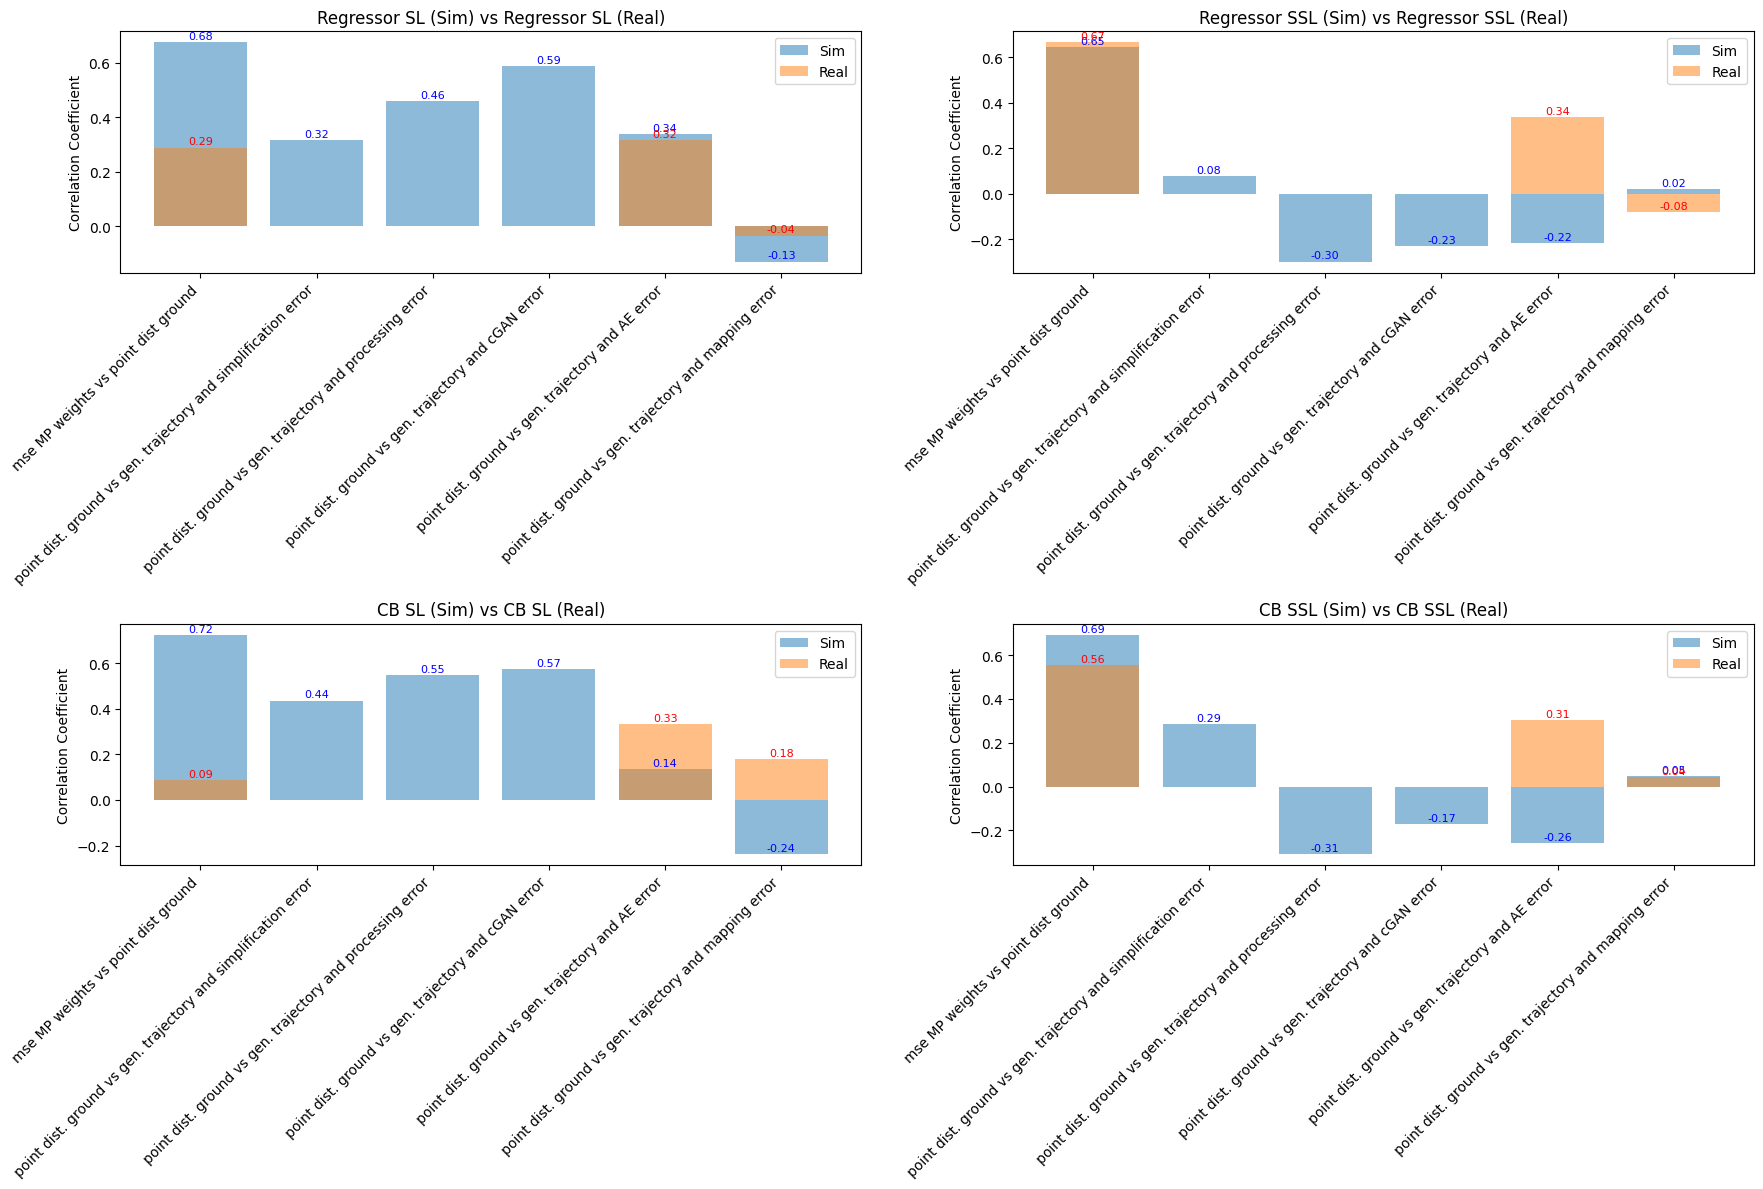

In [ ]:
def plot_correlation_comparison(corrs_files, file_names):
    corr_errs = [
        "mse MP weights vs point dist ground",
        "point dist. ground vs gen. trajectory and simplification error",
        "point dist. ground vs gen. trajectory and processing error",
        "point dist. ground vs gen. trajectory and cGAN error",
        "point dist. ground vs gen. trajectory and AE error",
        "point dist. ground vs gen. trajectory and mapping error"
    ]

    # Plotting for each comparison
    fig, axs = plt.subplots(2, 2, figsize=(18, 12))

    for i, ax in enumerate(axs.flat):
        x = range(len(corr_errs))
        y1 = corrs_files[i]  # First category
        y2 = corrs_files[i + 4]  # Corresponding category from the last four
        ax.bar(x, y1, alpha=0.5, label="Sim")
        ax.bar(x, y2, alpha=0.5, label="Real")
        ax.set_xticks(range(len(corr_errs)))
        ax.set_xticklabels(corr_errs, rotation=45, ha='right')
        ax.set_ylabel('Correlation Coefficient')
        ax.set_title(f'{file_names[i]} vs {file_names[i + 4]}')
        ax.legend()
        # Display values on top of bars
        for j, v in enumerate(y1):
            ax.text(j, v + 0.005, f'{v:.2f}', ha='center', va='bottom', fontsize=8, color='blue')
        for j, v in enumerate(y2):
            ax.text(j, v + 0.005, f'{v:.2f}', ha='center', va='bottom', fontsize=8, color='red')

    plt.tight_layout()
    plt.show()


plot_correlation_comparison(corrs_files, file_names)

Compute processing error correlations (available only for Sim)

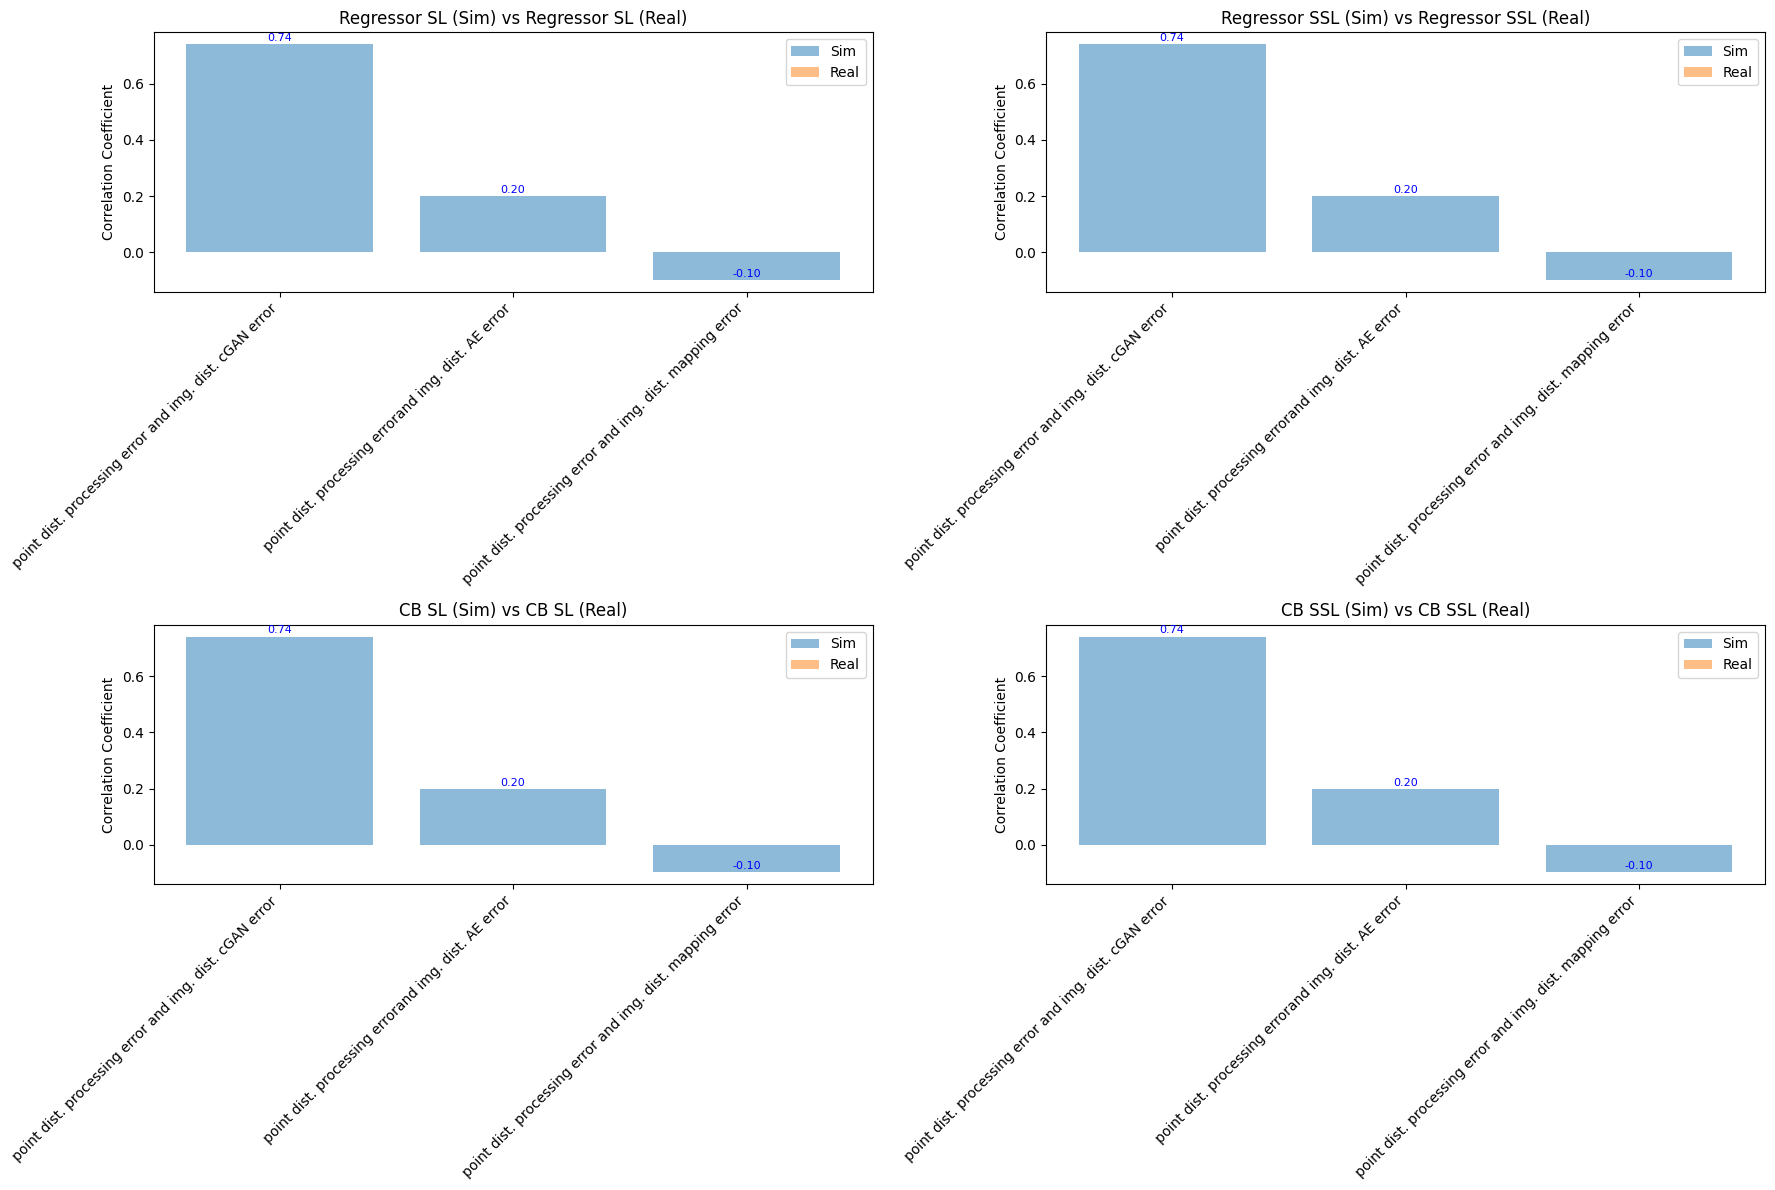

In [ ]:
def calculate_correlations_proc(file_paths, metric_names, remove_out=False):
    corrs_files = []
    for f, file_path in enumerate(file_paths):
      with open(file_path, 'rb') as file:
          metrics_list = pickle.load(file)
          if remove_out:
              # Remove outliers using the function (adjust iqr_multiplier if needed)
              metrics_list = remove_outliers(metrics_list, metric_names)
          corrs = []
          # Take the list of elements (each element is a list of 7 metrics)
          for metric_index, metric_name in enumerate(metric_names):
              if metric_index == 3:
                proc_error = [metrics[metric_index] for metrics in metrics_list]
              if metric_index == 4:
                gan_error = [metrics[metric_index] for metrics in metrics_list]
                # Calculate correlation coefficients between corresponding data points
                corr_proc_gan, _ = stats.spearmanr(proc_error, gan_error)
                corrs.append(corr_proc_gan)
              if metric_index == 5:
                ae_error = [metrics[metric_index] for metrics in metrics_list]
                # Calculate correlation coefficients between corresponding data points
                corr_proc_ae, _ = stats.spearmanr(proc_error, ae_error)
                corrs.append(corr_proc_ae)
              if metric_index == 6:
                map_error = [metrics[metric_index] for metrics in metrics_list]
                # Calculate correlation coefficients between corresponding data points
                corr_proc_map, _ = stats.spearmanr(proc_error, map_error)
                corrs.append(corr_proc_map)
          corrs_files.append(corrs)

    return corrs_files

corrs_files_proc = calculate_correlations_proc(file_paths, metric_names, remove_out=REMOVE_OUTLIERS)

def plot_correlation_comparison_proc(corrs_files, file_names):
    corr_errs = [
        "point dist. processing error and img. dist. cGAN error",
        "point dist. processing errorand img. dist. AE error",
        "point dist. processing error and img. dist. mapping error"
    ]

    # Plotting for each comparison
    fig, axs = plt.subplots(2, 2, figsize=(18, 12))

    for i, ax in enumerate(axs.flat):
        x = range(len(corr_errs))
        y1 = corrs_files[i]  # First category
        y2 = corrs_files[i + 4]  # Corresponding category from the last four
        ax.bar(x, y1, alpha=0.5, label="Sim")
        ax.bar(x, y2, alpha=0.5, label="Real")
        ax.set_xticks(range(len(corr_errs)))
        ax.set_xticklabels(corr_errs, rotation=45, ha='right')
        ax.set_ylabel('Correlation Coefficient')
        ax.set_title(f'{file_names[i]} vs {file_names[i + 4]}')
        ax.legend()
        # Display values on top of bars
        for j, v in enumerate(y1):
            ax.text(j, v + 0.005, f'{v:.2f}', ha='center', va='bottom', fontsize=8, color='blue')
        for j, v in enumerate(y2):
            ax.text(j, v + 0.05, f'{v:.2f}', ha='center', va='bottom', fontsize=8, color='red')

    plt.tight_layout()
    plt.show()
plot_correlation_comparison_proc(corrs_files_proc, file_names)